# qHTS for Inhibitors of human tyrosyl-DNA phosphodiesterase 1 (TDP1): qHTS in cells in absence of CPT

## Introduction
Human tyrosyl-DNA phosphodiesterase 1 (TDP1) is a novel repair gene, and we propose to use it as a new target for anticancer drug development. TDP1 is not an essential protein, but under treatment with topoisomerase I poison (camptothecin: CPT), TDP1 works as a critical factor for cell survival. To directly identify novel TDP1 inhibitors active in a cellular environment, we have knocked-out the Tdp1 gene in chicken DT40 cells (Tdp1-/-) and generated a complemented counterpart cells that contains a stable transfection of the human TDP1 gene (Tdp1-/-;hTDP1 cells). For the primary screen, Tdp1-/-;hTDP1 cells will be exposed to small molecules in the presence or absence of CPT, and their growth kinetics will be evaluated after 48 hours by measuring ATP activity. If a given compound shows a synergistic effect with CPT, this compound could inhibit the repair pathway of CPT-induced lesions including the TDP1-mediated repair pathway. The hit compounds will then be evaluated in the presence or absence of CPT using Tdp1-/- cells. If a compound shows synergistic effect with CPT in Tdp1-/-;hTDP1 cells, but not with Tdp1-/- cells, such compound could be involved in the TDP1-mediated repair pathway inhibition. In tertiary assays, biochemical gel-based assays will be used to assess whether the hit compounds specifically target TDP1.

## Imports

In [44]:
import sys
import copy
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from loaders.Loaders import CSVLoader
from standardizer.CustomStandardizer import CustomStandardizer
from scalers.sklearnScalers import StandardScaler
from compoundFeaturization.rdkitDescriptors import TwoDimensionDescriptors
from featureSelection.baseFeatureSelector import LowVarianceFS, BorutaAlgorithm
from compoundFeaturization.rdkitFingerprints import MorganFingerprint, RDKFingerprint, MACCSkeysFingerprint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sys.path.append('src')

## Initial exploration

### Import dataset
The first step, analysing this dataset, includes loading and displaying TDP1 data.

In [2]:
file = '../dataset/TDP1_activity_dataset.csv'
dataset = pd.read_csv(file, sep=',')
dataset.head()

PUBCHEM_RESULT_TAG  PUBCHEM_SID  PUBCHEM_CID PUBCHEM_ACTIVITY_OUTCOME  \
0                   1  109967258.0   50897788.0                   Active   
1                   2  144206324.0      65628.0                   Active   
2                   7  144206329.0      92140.0                   Active   
3                  16  144206459.0     148121.0                   Active   
4                  17  144206460.0   56840936.0                   Active   

   PUBCHEM_ACTIVITY_SCORE                               PUBCHEM_ACTIVITY_URL  \
0                    42.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
1                    41.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
2                    82.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
3                    94.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
4                    97.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   

   PUBCHEM_ASSAYDATA_COMMENT  Phenotype  Potency  Efficacy  Analysis Comment  \
0                        NaN  Inhibitor  14.1254  136.5470               NaN   
1                        NaN  Inhibitor  18.8375   82.1468               NaN   
2                        NaN  Inhibitor   5.9569   61.9164               NaN   
3                        NaN  Inhibitor   0.0237   97.3845               NaN   
4                        NaN  Inhibitor   0.0013   86.9215               NaN   

   Activity_Score               Curve_Description  Fit_LogAC50  Fit_HillSlope  \
0            42.0   Partial curve - high efficacy       -4.850         1.0100   
1            41.0   Partial curve - high efficacy       -4.725         1.9887   
2            82.0  Complete curve - high efficacy       -5.225         4.5045   
3            94.0  Complete curve - high efficacy       -7.625         2.4064   
4            97.0  Complete curve - high efficacy       -8.875         4.0950   

   Fit_R2  Fit_InfiniteActivity  Fit_ZeroActivity  Fit_CurveClass  \
0  0.9948             -134.4880            2.0597            -2.1   
1  0.9829              -82.6097           -0.4629            -2.1   
2  0.9691              -60.9817            0.9346            -1.1   
3  0.9971              -92.6583            4.7262            -1.1   
4  0.9961              -77.2253            9.6962            -1.1   

   Excluded_Points  Max_Response  Activity at 0.0000295000 uM  \
0        0 0 0 0 0     -106.3110                          NaN   
1  0 0 0 0 0 0 0 0      -70.9545                          NaN   
2  0 0 0 0 0 0 0 0      -61.0446                          NaN   
3  0 0 0 0 0 0 0 0      -95.5529                          NaN   
4  0 0 0 0 0 0 0 0      -80.1864                          NaN   

   Activity at 0.0000590000 uM  Activity at 0.0001503265 uM  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   Activity at 0.0002712146 uM  Activity at 0.0005895491 uM  \
0                          NaN                          NaN   
1                          NaN                      -3.2819   
2                          NaN                      -2.4216   
3                          NaN                       7.8276   
4                          NaN                       6.9054   

   Activity at 0.00117 uM  Activity at 0.00179 uM  Activity at 0.00299 uM  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                  1.1641   
2                     NaN                     NaN                 -0.2644   
3                     NaN                     NaN                  0.4451   
4                     NaN                     NaN                -73.9506   

   Activity at 0.00672 uM  Activity at 0.014 uM  Activity at 0.026 uM 

### Simple Analyses
This following step was taken to analyse how data presents itself along the lines and columns of the dataset.

In [3]:
dataset.size

1920000

In [4]:
dataset.shape

(40000, 48)

This dataset was loaded under the name 'dataset'. It has 40,000 distinct molecules and 48 variables. In total, there are 1,920,000 data entries.

In [5]:
dataset.columns

Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype',
       'Potency', 'Efficacy', 'Analysis Comment', 'Activity_Score',
       'Curve_Description', 'Fit_LogAC50', 'Fit_HillSlope', 'Fit_R2',
       'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Fit_CurveClass',
       'Excluded_Points', 'Max_Response', 'Activity at 0.0000295000 uM',
       'Activity at 0.0000590000 uM', 'Activity at 0.0001503265 uM',
       'Activity at 0.0002712146 uM', 'Activity at 0.0005895491 uM',
       'Activity at 0.00117 uM', 'Activity at 0.00179 uM',
       'Activity at 0.00299 uM', 'Activity at 0.00672 uM',
       'Activity at 0.014 uM', 'Activity at 0.026 uM', 'Activity at 0.040 uM',
       'Activity at 0.074 uM', 'Activity at 0.167 uM', 'Activity at 0.363 uM',
       'Activity at 0.628 uM', 'Activity at 0.975 uM', 'Activity at 1.849 uM',
       'Activity at 4.119 uM', 'Ac

| ColumnsName | Description |
| :-: | :-: |
| **PUBCHEM_RESULT_TAG** | This column contains an increasing number starting from one. |
| **PUBCHEM_SID** | PubChem SubstanceID |
| **PUBCHEM_CID** | PubChem CompoundID |
| **PUBCHEM_ACTIVITY_OUTCOME** | This field allows the submitter to make an expert judgment call about the activity of each test result. Using a number, the value is set to 1 (inactive) or 2 (active) based on whatever means appropriate. In addition to active/inactive, this field can also be set to 3 (inconclusive), 4 (unspecified) or 5 (probe). The 'probe' designation indicates that the activity of the test result has been tested and confirmed though multiple rounds of experimental inquiry |
| **PUBCHEM_ACTIVITY_SCORE** | The activity of a test result may be assigned a normalized score between 0 and 100 where the most active result rows have scores closer to 100 and inactive closer to 0, so that one can rank the result based on this data and prioritize hits |
| **PUBCHEM_ACTIVITY_URL** | An URL may optionally be provided for Assay Data reported for this Substance in this column. |
| **PUBCHEM_ASSAYDATA_COMMENT** | Textual annotation and comments |
| **Potency** | Concentration at which compound exhibits half-maximal efficacy |
| **Efficacy** | Maximal efficacy of compound, reported as a percentage of control |
| **Analysis Comment** | Annotation/notes on a particular compound's data or its analysis |
| **Activity_Score** | Activity score |
| **Curve_Description** | A description of dose-response curve quality |
| **Fit_LogAC50** | The logarithm of the AC50 from a fit of the data to the Hill equation (calculated based on Molar Units) |
| **Fit_HillSlope** | The Hill slope from a fit of the data to the Hill equation |
| **Fit_R2** | R^2 fit value of the curve. Closer to 1.0 equates to better Hill equation fit |
| **Fit_InfiniteActivity** | The asymptotic efficacy from a fit of the data to the Hill equation |
| **Fit_ZeroActivity** | Efficacy at zero concentration of compound from a fit of the data to the Hill equation |
| **Fit_CurveClass** | Numerical encoding of curve description for the fitted Hill equation |
| **Excluded_Points** | Which dose-response titration points were excluded from analysis based on outlier analysis |
| **Max_Response** | Maximum activity observed for compound (usually at highest concentration tested) |
| **Activity at xx uM*** | % Activity at given concentration |
| **Compound QC** | NCGC designation for data stage: 'qHTS', 'qHTS Verification', 'Secondary Profiling' |
| **smiles** | SMILES (Simplified Molecular Input Line Entry System) is a chemical notation that allows a user to represent a chemical structure in a way that can be used by the computer. |

*Activity at xx uM refers to all columns that shows the activity of a molecule at a certain concentration.

In [6]:
dataset.dtypes

PUBCHEM_RESULT_TAG               int64
PUBCHEM_SID                    float64
PUBCHEM_CID                    float64
PUBCHEM_ACTIVITY_OUTCOME        object
PUBCHEM_ACTIVITY_SCORE         float64
PUBCHEM_ACTIVITY_URL            object
PUBCHEM_ASSAYDATA_COMMENT      float64
Phenotype                       object
Potency                        float64
Efficacy                       float64
Analysis Comment               float64
Activity_Score                 float64
Curve_Description               object
Fit_LogAC50                    float64
Fit_HillSlope                  float64
Fit_R2                         float64
Fit_InfiniteActivity           float64
Fit_ZeroActivity               float64
Fit_CurveClass                 float64
Excluded_Points                 object
Max_Response                   float64
Activity at 0.0000295000 uM    float64
Activity at 0.0000590000 uM    float64
Activity at 0.0001503265 uM    float64
Activity at 0.0002712146 uM    float64
Activity at 0.0005895491 

In [7]:
sub_dataset = dataset[['Potency', 'Efficacy', 'Fit_LogAC50', 'Fit_HillSlope', 'Fit_R2',
       'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Activity at 0.0000295000 uM',
       'Activity at 0.0000590000 uM', 'Activity at 0.0001503265 uM',
       'Activity at 0.0002712146 uM', 'Activity at 0.0005895491 uM',
       'Activity at 0.00117 uM', 'Activity at 0.00179 uM',
       'Activity at 0.00299 uM', 'Activity at 0.00672 uM',
       'Activity at 0.014 uM', 'Activity at 0.026 uM', 'Activity at 0.040 uM',
       'Activity at 0.074 uM', 'Activity at 0.167 uM', 'Activity at 0.363 uM',
       'Activity at 0.628 uM', 'Activity at 0.975 uM', 'Activity at 1.849 uM',
       'Activity at 4.119 uM', 'Activity at 9.037 uM', 'Activity at 15.83 uM',
       'Activity at 21.08 uM', 'Activity at 46.23 uM', 'Activity at 92.54 uM',
       'Activity at 165.6 uM']]

sub_dataset.describe()

Potency      Efficacy   Fit_LogAC50  Fit_HillSlope        Fit_R2  \
count  20030.000000  20030.000000  21875.000000   38208.000000  38208.000000   
mean      14.576385     96.992453     -5.004474       2.976413      0.875302   
std        7.230402     21.335634      0.545511       1.482360      0.179660   
min        0.001300      4.737700     -9.075000       0.200000      0.300300   
25%        9.200000     82.368825     -5.086200       1.788500      0.821400   
50%       16.360100     96.297200     -4.786200       2.533400      0.970600   
75%       20.596200    111.422250     -4.686200       4.954900      0.993700   
max       38.869900    186.037000     -4.410400       4.954900      1.000000   

       Fit_InfiniteActivity  Fit_ZeroActivity  Activity at 0.0000295000 uM  \
count          38208.000000      38208.000000                          0.0   
mean             -55.874923         -2.191756                          NaN   
std               48.730687          9.992784                          NaN   
min             -171.676000       -126.305000                          NaN   
25%             -100.585000         -6.234325                          NaN   
50%              -69.471800         -1.248000                          NaN   
75%               -8.455775          2.976475                          NaN   
max               55.568000         46.025900                          NaN   

       Activity at 0.0000590000 uM  Activity at 0.0001503265 uM  \
count                          0.0                     2.000000   
mean                           NaN                     2.403950   
std                            NaN                     2.569131   
min                            NaN                     0.587300   
25%                            NaN                     1.495625   
50%                            NaN                     2.403950   
75%                            NaN                     3.312275   
max                            NaN                     4.220600   

       Activity at 0.0002712146 uM  Activity at 0.0005895491 uM  \
count                          0.0                   271.000000   
mean                           NaN                    -3.557925   
std                            NaN                    14.086167   
min                            NaN                   -89.497200   
25%                            NaN                    -5.878100   
50%                            NaN                    -1.091000   
75%                            NaN                     2.372200   
max                            NaN                    23.740700   

       Activity at 0.00117 uM  Activity at 0.00179 uM  Activity at 0.00299 uM  \
count               12.000000                9.000000            38700.000000   
mean                -0.236175                2.232467               -2.767132   
std                  8.757193                4.238672               10.600459   
min                -15.210000               -6.975500             -124.585000   
25%                 -5.627875                0.451300               -7.230900   
50%                 -0.126950                4.153200               -1.399500   
75%                  2.088900                5.143500                2.597625   
max                 18.811200                6.595400               43.627300   

       Activity at 0.00672 uM  Activity at 0.014 uM  Activity at 0.026 uM  \
count               32.000000           1692.000000             71.000000   
mean                -2.647712             -1.030801             -4.937286   
std                 17.535983             11.429548             20.749187   
min                -90.796900           -103.706000           -111.866000   
25%                 -5.573800             -4.143900             -4.231150   
50%                 -0.156150              0.151300              0.791900   
75%                  2.806800              3.728025              2.627950   
max                 26.864900     

## Pre-Processing

The number of non attributed values (NA's) will be counted.

### Visualization of the NA's

In [8]:
print(dataset.isna().sum())
print(f"TOTAL: {dataset.isna().sum().sum()}")

PUBCHEM_RESULT_TAG                 0
PUBCHEM_SID                        0
PUBCHEM_CID                       18
PUBCHEM_ACTIVITY_OUTCOME           0
PUBCHEM_ACTIVITY_SCORE             0
PUBCHEM_ACTIVITY_URL               0
PUBCHEM_ASSAYDATA_COMMENT      40000
Phenotype                          0
Potency                        19970
Efficacy                       19970
Analysis Comment               40000
Activity_Score                     1
Curve_Description              19955
Fit_LogAC50                    18125
Fit_HillSlope                   1792
Fit_R2                          1792
Fit_InfiniteActivity            1792
Fit_ZeroActivity                1792
Fit_CurveClass                     0
Excluded_Points                 1792
Max_Response                       0
Activity at 0.0000295000 uM    40000
Activity at 0.0000590000 uM    40000
Activity at 0.0001503265 uM    39998
Activity at 0.0002712146 uM    40000
Activity at 0.0005895491 uM    39729
Activity at 0.00117 uM         39988
A

As we can see, there are a few columns that are completly filled by NA's, such as "PUBCHEM_ASSAYDATA_COMMENT" and "Analysis Comment". Therefore, these columns do not provide any type of information to the dataset.
It is import to note that are 10 molecules with missing SMILE.

We can observe that more than 50% of all data entries are NA's.

### Drop specific features

In [9]:
dataset = dataset.dropna(axis=1, how='all')
dataset.drop(['PUBCHEM_ACTIVITY_URL', 'Compound QC'], axis=1)
dataset = dataset[dataset['smiles'].notna()]

print(dataset.shape)
print(dataset.columns)

(39990, 43)
Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'Phenotype', 'Potency', 'Efficacy',
       'Activity_Score', 'Curve_Description', 'Fit_LogAC50', 'Fit_HillSlope',
       'Fit_R2', 'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Fit_CurveClass',
       'Excluded_Points', 'Max_Response', 'Activity at 0.0001503265 uM',
       'Activity at 0.0005895491 uM', 'Activity at 0.00117 uM',
       'Activity at 0.00179 uM', 'Activity at 0.00299 uM',
       'Activity at 0.00672 uM', 'Activity at 0.014 uM',
       'Activity at 0.026 uM', 'Activity at 0.040 uM', 'Activity at 0.074 uM',
       'Activity at 0.167 uM', 'Activity at 0.363 uM', 'Activity at 0.628 uM',
       'Activity at 0.975 uM', 'Activity at 1.849 uM', 'Activity at 4.119 uM',
       'Activity at 9.037 uM', 'Activity at 15.83 uM', 'Activity at 21.08 uM',
       'Activity at 46.23 uM', 'Activity at 92.54 uM', 'Activity at 165.6 u

3 columns consisting only of NA's were removed, which reduced the dataset to 45 columns in total.
Columns whose information will not be useful for further analysis were also removed. More specifically, the columns "PUBCHEM_ACTIVITY_URL" and "Compound QC" have been removed, reducing the column total to 43.
The 10 molecules that did not have SMILE notation were removed from the dataset.

In [10]:
dataset_1 = pd.DataFrame.copy(dataset)
dataset_1["PUBCHEM_ACTIVITY_OUTCOME"] = dataset_1["PUBCHEM_ACTIVITY_OUTCOME"].replace({"Active":1, "Inactive": 0})
dataset_1.to_csv("../dataset/TDP1_activity_dataset_binary_value.csv")
dataset_1 = None

To help with future analysis, the "PUBCHEM_ACTIVITY_OUTCOME" categorical variable was transformed into a binary variable.

### Graphic Analyses
#### Activity_outcome and Phenotype

In [11]:
activity = dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size()
labels_activity = dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size().index
dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size()

PUBCHEM_ACTIVITY_OUTCOME
Active      19992
Inactive    19998
dtype: int64

In [12]:
fenotipo = dataset.groupby('Phenotype').size()
labels_fenotipo = dataset.groupby('Phenotype').size().index
dataset.groupby('Phenotype').size()

Phenotype
Activator       60
Inactive     19938
Inhibitor    19992
dtype: int64

Text(0.5, 1.0, 'Phenotype')

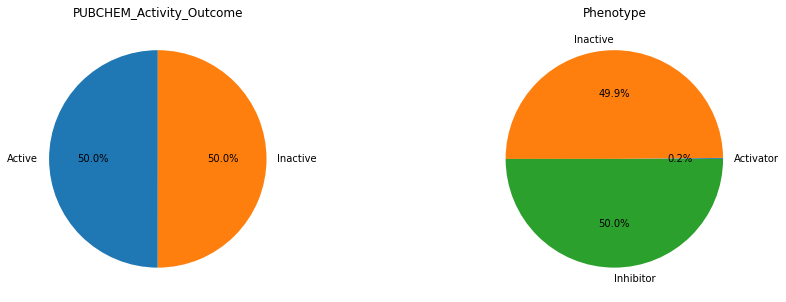

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.pie(activity, labels=labels_activity, autopct='%1.1f%%', startangle=90)
ax1.set_title('PUBCHEM_Activity_Outcome')
ax2.pie(fenotipo, labels=labels_fenotipo, autopct='%1.1f%%', startangle=360)
ax2.set_title('Phenotype')

As we can see in the "PUBCHEM_Activity_Outcome" pie chart, the data is balanced for binary classification.
In the "Phenotype" pie chart, the overall multiclass is very imbalanced. However, the data is balanced between the 'Inactive' and 'Inhibitor' phenotypes.

#### Boxplots of Activity at 0.00299 uM, 0.363 uM, 1.849 uM, 9.037 uM and 46.23 uM

<AxesSubplot:title={'center':'Activity at 0.00299 uM'}, ylabel='Activity at 0.00299 uM'>

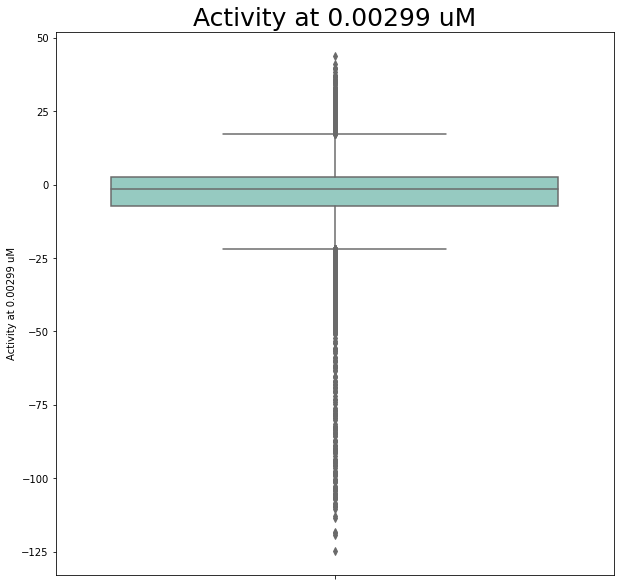

In [14]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 0.00299 uM", fontsize=25)
sns.boxplot(y="Activity at 0.00299 uM",
            data=dataset, palette="Set3")

In [15]:
dataset["Activity at 0.00299 uM"].describe()

count    38695.000000
mean        -2.765257
std         10.593629
min       -124.585000
25%         -7.230600
50%         -1.400000
75%          2.597650
max         43.627300
Name: Activity at 0.00299 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 0.363 uM'}, ylabel='Activity at 0.363 uM'>

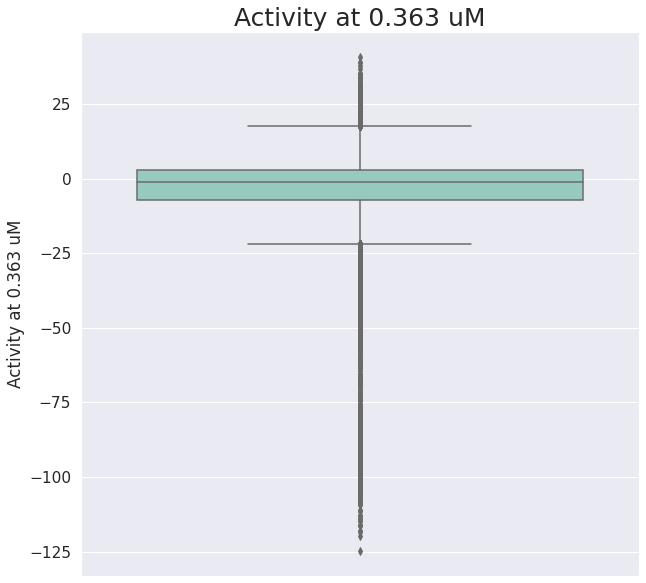

In [16]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 0.363 uM", fontsize=25)
sns.boxplot(y="Activity at 0.363 uM",
            data=dataset, palette="Set3")

In [17]:
dataset["Activity at 0.363 uM"].describe()

count    39760.000000
mean        -2.914642
std         11.702945
min       -124.830000
25%         -7.090875
50%         -1.263200
75%          2.736000
max         40.747500
Name: Activity at 0.363 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 1.849 uM'}, ylabel='Activity at 1.849 uM'>

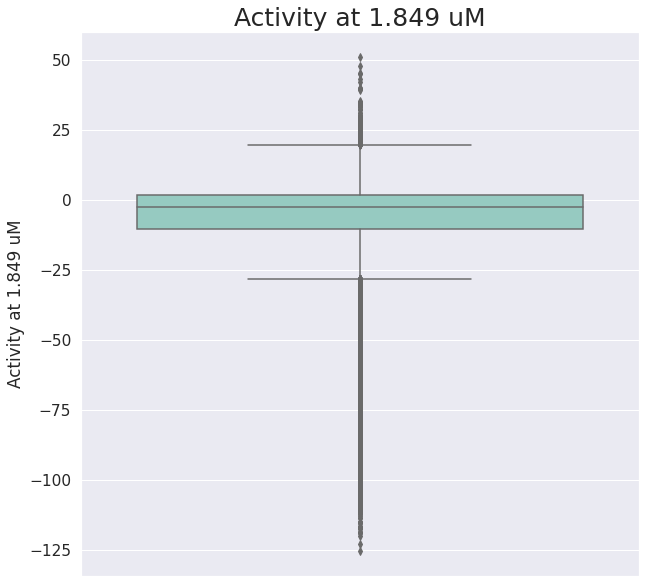

In [18]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 1.849 uM", fontsize=25)
sns.boxplot(y="Activity at 1.849 uM", data=dataset, palette="Set3")

In [19]:
dataset["Activity at 1.849 uM"].describe()

count    39742.000000
mean        -6.283120
std         16.475083
min       -125.457000
25%        -10.335850
50%         -2.634900
75%          1.663600
max         50.993300
Name: Activity at 1.849 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 9.037 uM'}, ylabel='Activity at 9.037 uM'>

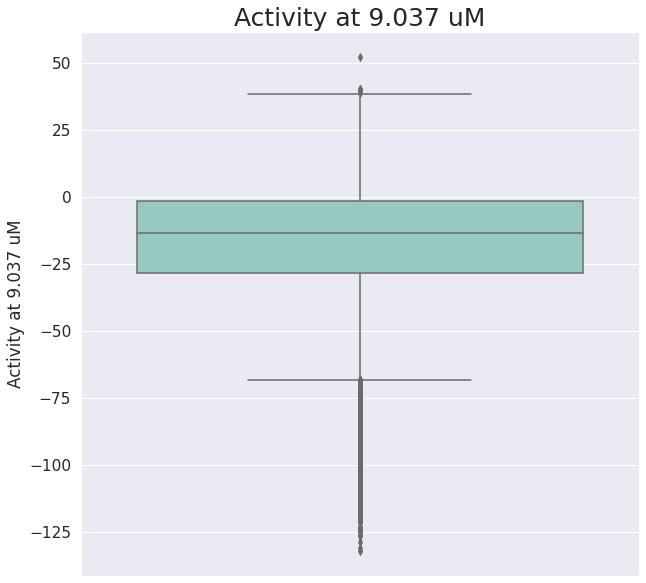

In [20]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 9.037 uM", fontsize=25)
sns.boxplot(y="Activity at 9.037 uM", data=dataset, palette="Set3")

In [21]:
dataset["Activity at 9.037 uM"].describe()

count    39189.000000
mean       -20.564183
std         27.542152
min       -132.226000
25%        -28.187400
50%        -13.456500
75%         -1.370100
max         52.388100
Name: Activity at 9.037 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 46.23 uM'}, ylabel='Activity at 46.23 uM'>

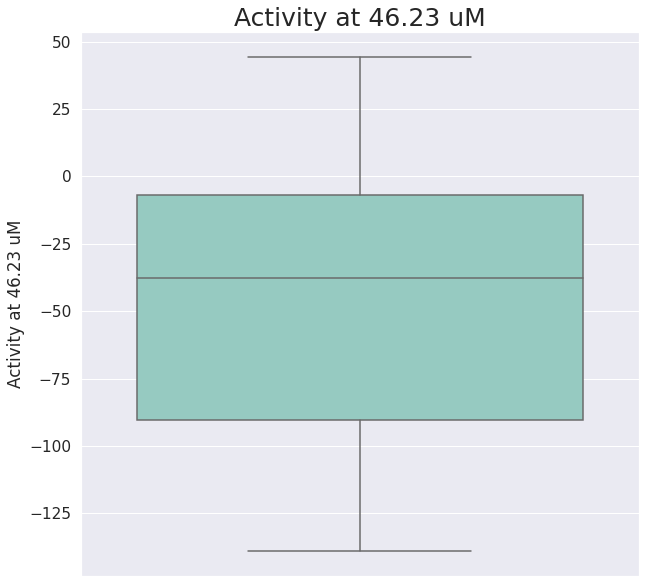

In [22]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 46.23 uM", fontsize=25)
sns.boxplot(y="Activity at 46.23 uM", data=dataset, palette="Set3")

In [23]:
dataset["Activity at 46.23 uM"].describe()

count    39941.000000
mean       -48.307422
std         42.879640
min       -139.063000
25%        -90.492700
50%        -37.857500
75%         -6.688500
max         44.389300
Name: Activity at 46.23 uM, dtype: float64

## Standardize molecules

In [24]:
def standardize(dataset, id_field ,mols_field,class_field):

    loader = CSVLoader(dataset,
                       id_field=id_field,
                       mols_field = mols_field,
                       labels_fields = class_field)

    dataset = loader.create_dataset()

    standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

    CustomStandardizer(params = standardisation_params).standardize(dataset)

    return dataset

In [25]:
dataset = standardize("../dataset/TDP1_activity_dataset_binary_value.csv", "PUBCHEM_CID", "smiles", "PUBCHEM_ACTIVITY_OUTCOME")
dataset.save_to_csv("../dataset/standardized.csv")

Standardizing datapoint 0


RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:

[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Removed negative charge.
[00:46:22] Removed negative charge.
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger


RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:

harger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:

RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:46:22] Running Uncharger
RDKit INFO: [00:

22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Uncharger
[00:46:22] Running Un

RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:

charger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46

RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:46:23] Running Uncharger
RDKit INFO: [00:

:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running Uncharger
[00:46:23] Running U

RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:

ncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:4

RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:46:24] Running Uncharger
RDKit INFO: [00:

6:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running Uncharger
[00:46:24] Running 

RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 1000
Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:

RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:

46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running

RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:46:25] Running Uncharger
RDKit INFO: [00:

46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running Uncharger
[00:46:25] Running

RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00

RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:

:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Runnin

RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:46:26] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[00:46:26] Running Uncharger
[0

RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:

0:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Runni

RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:46:27] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[00:46:27] Running Uncharger
[

RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:46:28] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger
[00:46:28] Running Uncharger


RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:

[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Run

RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:29] Running Uncharger

RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:46:29] Running Uncharger
RDKit INFO: [00:


[00:46:29] Running Uncharger
[00:46:29] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Ru

RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharge

RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:46:30] Running Uncharger
RDKit INFO: [00:

r
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] Running Uncharger
[00:46:30] R

RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 3000
unning Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharg

RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:46:31] Running Uncharger
RDKit INFO: [00:

er
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] Running Uncharger
[00:46:31] 

RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Unchar

RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:46:32] Running Uncharger
RDKit INFO: [00:

ger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32] Running Uncharger
[00:46:32]

RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncha

RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:

rger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33

RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:33] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:33] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Unch

RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 4000
arger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:3

RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:46:34] Running Uncharger
RDKit INFO: [00:

4] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Uncharger
[00:46:34] Running Unc

RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:46:35] Running Uncharger
RDKit INFO: [00:

harger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:35] Running Uncharger
[00:46:

RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:

charger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46

RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:46:36] Running Uncharger
RDKit INFO: [00:

:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running Uncharger
[00:46:36] Running U

RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:

ncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:4

RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:46:37] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:37] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:

RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:

46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running

RDKit INFO: [00:46:38] Removed negative charge.
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Running Uncharger
RDKit INFO: [00:46:38] Removed negative charge.
RDKit INFO: [00:46:38] Running Uncharger
RD

 negative charge.
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Removed negative charge.
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running Uncharger
[00:46:38] Running

RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00

RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:46:39] Running Uncharger
RDKit INFO: [00:

:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Running Uncharger
[00:46:39] Runnin

RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncha

RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:46:40] Running Uncharger
RDKit INFO: [00:

rger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40] Running Uncharger
[00:46:40

RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Unch

RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:

arger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:4

RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:46:41] Running Uncharger
RDKit INFO: [00:

1] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Uncharger
[00:46:41] Running Unc

RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:

harger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:

RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:46:42] Running Uncharger
RDKit INFO: [00:

42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Uncharger
[00:46:42] Running Un

RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:

charger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46

RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:46:43] Running Uncharger
RDKit INFO: [00:

:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running Uncharger
[00:46:43] Running U

RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:

ncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:4

RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:46:44] Running Uncharger
RDKit INFO: [00:

6:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running Uncharger
[00:46:44] Running 

RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:

RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:

46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running

RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:46:45] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00:46:45] Running Uncharger
[00

RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:

:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Runnin

RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:46:46] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[00:46:46] Running Uncharger
[0

RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:

0:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Runni

RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:46:47] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[00:46:47] Running Uncharger
[

RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:

00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Runn

RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:46:48] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger
[00:46:48] Running Uncharger


RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:

[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Run

RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger

RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:46:49] Running Uncharger
RDKit INFO: [00:


[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Running Uncharger
[00:46:49] Ru

RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharge

RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:46:50] Running Uncharger
RDKit INFO: [00:

r
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] Running Uncharger
[00:46:50] R

RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:46:51] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharg

RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:

er
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] Running Uncharger
[00:46:51] 

RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Unchar

RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:46:52] Running Uncharger
RDKit INFO: [00:

ger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52] Running Uncharger
[00:46:52]

RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncha

RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:46:53] Running Uncharger
RDKit INFO: [00:

rger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Removed negative charge.
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[00:46:53] Running Uncharger
[0

RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:

0:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Runni

RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:46:54] Running Uncharger
RDKit INFO: [00:

0:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Running Uncharger
[00:46:54] Runni

RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[

RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:

00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:55] Runn

RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:55] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:46:55] Running Uncharger
[00:46:55] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger


RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:46:56] Running Uncharger
RDKit INFO: [00:

[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Run

RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger
[00:46:56] Running Uncharger

RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:


[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Ru

RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:46:57] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharger
[00:46:57] Running Uncharge

RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:

r
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] R

RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:46:58] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharger
[00:46:58] Running Uncharg

RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:

er
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] 

RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Unchar

RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:46:59] Running Uncharger
RDKit INFO: [00:

ger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59] Running Uncharger
[00:46:59]

RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncha

RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:47:00] Running Uncharger
RDKit INFO: [00:

rger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00] Running Uncharger
[00:47:00

RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Unch

RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:47:01] Running Uncharger
RDKit INFO: [00:

arger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:01] Running Uncharger
[00:47:0

RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:

2] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Unc

RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:47:02] Running Uncharger
RDKit INFO: [00:

harger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:02] Running Uncharger
[00:47:

RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 13000


RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:47:03] Running Uncharger
RDKit INFO: [00:

03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Uncharger
[00:47:03] Running Un

RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:

charger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47

RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:

:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running U

RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:47:04] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:47:04] Running Uncharger
[00:4

RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:

7:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running 

RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:47:05] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:47:05] Running Uncharger
[00:

RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:

47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running

RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 14000
 Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[0

RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:47:06] Running Uncharger
RDKit INFO: [00:

:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Running Uncharger
[00:47:06] Runnin

RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[0

RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:47:07] Running Uncharger
RDKit INFO: [00:

0:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Running Uncharger
[00:47:07] Runni

RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[

RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:47:08] Running Uncharger
RDKit INFO: [00:

00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Running Uncharger
[00:47:08] Runn

RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger


RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 15000
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Running Uncharger
[00:47:09] Ru

RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:47:09] Running Uncharger
RDKit INFO: [00:

ger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Run

RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger

RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:47:10] Running Uncharger
RDKit INFO: [00:


[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Running Uncharger
[00:47:10] Ru

RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:

:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running Uncharger
[00:47:11] Running U

RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:47:11] Running Uncharger
RDKit INFO: [00:

7:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running 

RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:

RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:47:12] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 16000
47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Running Uncharger
[00:47:12] Runnin

RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00

RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:47:13] Running Uncharger
RDKit INFO: [00:

:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Running Uncharger
[00:47:13] Runnin

RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[0

RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:

0:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Runni

RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:47:14] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[00:47:14] Running Uncharger
[

RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:

00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Running Uncharger
[00:47:15] Runn

RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:15] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:

[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Run

RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:47:16] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger
[00:47:16] Running Uncharger

RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:


[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Ru

RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharge

RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:47:17] Running Uncharger
RDKit INFO: [00:

r
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] Running Uncharger
[00:47:17] R

RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharg

RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:18] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 18000
er
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:18] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19]

RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Unchar

RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:19] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:

ger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:19] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20]

RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncha

RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:47:20] Running Uncharger
RDKit INFO: [00:

rger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20] Running Uncharger
[00:47:20

RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Unch

RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:

arger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:2

RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:47:21] Running Uncharger
RDKit INFO: [00:

1] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Uncharger
[00:47:21] Running Unc

RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:

harger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:

RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:

22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Un

RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:47:22] Running Uncharger
RDKit INFO: [00:

charger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47:22] Running Uncharger
[00:47

RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:

:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running U

RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:4

RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:47:23] Running Uncharger
RDKit INFO: [00:

r
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] Running Uncharger
[00:47:23] R

RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharg

RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:

er
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Removed negative charge.
[00:47:24] Removed negative charge.
[00:47:24] Running Uncharger
[00:47:24] Removed negativ

RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:47:24] Running Uncharger
RDKit INFO: [00:

00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Running Uncharger
[00:47:24] Runn

RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Removed negative charge.
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INF

ing Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Removed negative charge.
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Removed negative charge.
[00:47:25] Removed negative charge.
[00:47:25] Removed negative charge.
[00:47:25] Removed negative charge.
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Unch

RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:47:25] Running Uncharger
RDKit INFO: [00:

[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Run

RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:25] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger

RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:


[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Ru

RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:47:26] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharge

RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:

r
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:26] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] R

RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharg

RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:47:27] Running Uncharger
RDKit INFO: [00:

er
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] Running Uncharger
[00:47:27] 

RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Unchar

RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:47:28] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncharger
[00:47:28] Running Uncha

RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:

rger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29

RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Unch

RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:47:29] Running Uncharger
RDKit INFO: [00:

arger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:29] Running Uncharger
[00:47:2

RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:

0] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Unc

RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:

harger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:

RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:47:30] Running Uncharger
RDKit INFO: [00:

30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Uncharger
[00:47:30] Running Un

RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:

charger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47

RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:

:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running U

RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:47:31] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:47:31] Running Uncharger
[00:4

RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:

7:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running 

RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:

RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:47:32] Running Uncharger
RDKit INFO: [00:

47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running Uncharger
[00:47:32] Running

RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00

RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:

:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Runnin

RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:47:33] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[00:47:33] Running Uncharger
[0

RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 24000
0:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Runn

RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[

RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:47:34] Running Uncharger
RDKit INFO: [00:

00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Running Uncharger
[00:47:34] Runn

RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger


RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:

[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Run

RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:47:35] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger
[00:47:35] Running Uncharger

RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:


[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Ru

RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 25000
nning Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharg

RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:47:36] Running Uncharger
RDKit INFO: [00:

r
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] Running Uncharger
[00:47:36] R

RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharg

RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:

RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:47:37] Running Uncharger
RDKit INFO: [00:

47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running Uncharger
[00:47:37] Running

RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00

RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:

:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Runnin

RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:47:38] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 26000
g Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[00:47:38] Running Uncharger
[

RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:

0:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Runni

RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[

RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:47:39] Running Uncharger
RDKit INFO: [00:

00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Running Uncharger
[00:47:39] Runn

RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger


RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:

[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Run

RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:40] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:40] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger

RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 27000

[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] R

RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharger
[00:47:41] Running Uncharge

RDKit INFO: [00:47:41] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:

r
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] R

RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharg

RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:47:42] Running Uncharger
RDKit INFO: [00:

er
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] Running Uncharger
[00:47:42] 

RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Unchar

RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00

RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:

:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Runnin

RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:43] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:43] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncha

RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:

rger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44

RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:47:44] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Uncharger
[00:47:44] Running Unch

RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:

arger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:4

RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:

5] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Unc

RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:47:45] Running Uncharger
RDKit INFO: [00:

harger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:45] Running Uncharger
[00:47:

RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:

46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Un

RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:

charger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47

RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:47:46] Running Uncharger
RDKit INFO: [00:

:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running Uncharger
[00:47:46] Running U

RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:4

RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:

7:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running 

RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:47:47] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:47:47] Running Uncharger
[00:

RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:

47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running

RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:

 Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00

RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:47:48] Running Uncharger
RDKit INFO: [00:

:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Running Uncharger
[00:47:48] Runnin

RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:

g Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[0

RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:47:49] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[00:47:49] Running Uncharger
[

RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:

00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Runn

RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:47:50] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger


RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:

[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:50] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Removed negative charge.
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:

RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:

51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Un

RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:47:51] Running Uncharger
RDKit INFO: [00:

charger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47:51] Running Uncharger
[00:47

RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:

:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running U

RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:4

RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:47:52] Running Uncharger
RDKit INFO: [00:

7:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running Uncharger
[00:47:52] Running 

RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:

Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:

RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:

47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Removed negative charge.
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] 

RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:47:53] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Uncharger
[00:47:53] Running Unchar

RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:

ger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54]

RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncha

RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:47:54] Running Uncharger
RDKit INFO: [00:

rger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:54] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55

RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Unch

RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:47:55] Running Uncharger
RDKit INFO: [00:

arger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:55] Running Uncharger
[00:47:5

RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:

6] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Unc

RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:

harger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:

RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:47:56] Running Uncharger
RDKit INFO: [00:

56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Uncharger
[00:47:56] Running Un

RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:

charger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47

RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:

:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running U

RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:57] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:

ncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:57] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:4

RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:

r
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] R

RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:47:58] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharger
[00:47:58] Running Uncharg

RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:

er
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] 

RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Unchar

RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:47:59] Running Uncharger
RDKit INFO: [00:

ger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59] Running Uncharger
[00:47:59]

RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:

ger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00]

RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncha

RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:48:00] Running Uncharger
RDKit INFO: [00:

rger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00] Running Uncharger
[00:48:00

RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Unch

RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:

arger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:0

RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:48:01] Running Uncharger
RDKit INFO: [00:

00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Running Uncharger
[00:48:01] Runn

RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger


RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:48:02] Running Uncharger
RDKit INFO: [00:

[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Run

RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:

ning Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger
[00:48:02] Running Uncharger

RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:


[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Ru

RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:48:03] Running Uncharger
RDKit INFO: [00:

nning Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharge

RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:

r
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] Running Uncharger
[00:48:03] R

RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:

r
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] R

RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:48:04] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharg

RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:

er
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] Running Uncharger
[00:48:04] 

RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Unchar

RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:48:05] Running Uncharger
RDKit INFO: [00:

ger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05] Running Uncharger
[00:48:05]

RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:

 Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncha

RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:48:06] Running Uncharger
RDKit INFO: [00:

:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running U

RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:

] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Uncharger
[00:48:06] Running Unch

RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:

arger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:0

RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:48:07] Running Uncharger
RDKit INFO: [00:

7] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Unc

RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:

harger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:07] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:

RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:

08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Un

RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:08] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:

charger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48:08] Running Uncharger
[00:48

RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 38000
:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running 

RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:

ncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:4

RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:48:09] Running Uncharger
RDKit INFO: [00:

r
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] Running Uncharger
[00:48:09] R

RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:

unning Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharg

RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:48:10] Running Uncharger
RDKit INFO: [00:

er
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] Running Uncharger
[00:48:10] 

RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:

Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Unchar

RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:

ger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11]

RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:48:11] Running Uncharger
RDKit INFO: [00:

Standardizing datapoint 39000
 Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Uncharger
[00:48:11] Running Unch

RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:

rger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12

RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:

0:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Runni

RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:48:12] Running Uncharger
RDKit INFO: [00:

ng Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[00:48:12] Running Uncharger
[

RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:

00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Runn

RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:48:13] Running Uncharger
RDKit INFO: [00:

ing Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger
[00:48:13] Running Uncharger


RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:

[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Running Uncharger
[00:48:14] Run

RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:48:14] Running Uncharger
RDKit INFO: [00:

In [26]:
dataset = pd.read_csv("../dataset/standardized.csv")

# TESTE

In [27]:
def get_molecular_descriptors(molecules):
    descrip = np.zeros((len(molecules), 14))

    i = 0

    for molec in molecules:
        descrip[i, 0] = Chem.Descriptors.ExactMolWt(molec)
        descrip[i, 1] = Chem.Crippen.MolLogP(molec)
        descrip[i, 2] = Chem.Lipinski.RingCount(molec)
        descrip[i, 3] = Chem.Lipinski.NumAliphaticCarbocycles(molec)
        descrip[i, 4] = Chem.Lipinski.NumAliphaticHeterocycles(molec)
        descrip[i, 5] = Chem.Lipinski.NumAromaticRings(molec)
        descrip[i, 6] = Chem.Descriptors.TPSA(molec)
        descrip[i, 7] = Chem.Lipinski.NHOHCount(molec)
        descrip[i, 8] = Chem.Lipinski.NOCount(molec)
        descrip[i, 9] = Chem.Lipinski.NumHAcceptors(molec)
        descrip[i, 10] = Chem.Lipinski.NumHDonors(molec)
        descrip[i, 11] = Chem.Descriptors.NumValenceElectrons(molec)
        descrip[i, 12] = Chem.Lipinski.NumRotatableBonds(molec)
        descrip[i, 13] = Chem.Descriptors.NumRadicalElectrons(molec)
        i += 1

    columns = ["Molecular Weight", "LogP", "Ring Count", "NumAliphaticCarbocycles", "NumAliphaticHeterocycles",
               "NumAromaticRings", "TPSA", "NHOHCount", "NOCount", "NumHAcceptors", "NumHDonors", "NumValenceElectrons",
               "NumRotatableBonds", "NumRadicalElectrons"]

    df = pd.DataFrame(descrip, columns=columns)
    return df

In [28]:
molecules = [Chem.MolFromSmiles(smile) for smile in dataset.mols]

In [29]:
molecular_descriptors = get_molecular_descriptors(molecules)
molecular_descriptors["activity"] = dataset.y
molecular_descriptors

Molecular Weight     LogP  Ring Count  NumAliphaticCarbocycles  \
0            272.082874  2.99770         3.0                      0.0   
1            357.101082  3.26460         2.0                      0.0   
2            656.305744  3.68044         3.0                      0.0   
3            477.176067  0.98160         3.0                      0.0   
4            540.207627  1.42960         2.0                      0.0   
...                 ...      ...         ...                      ...   
39985        388.145678  2.43620         3.0                      0.0   
39986        235.059306  0.61890         2.0                      0.0   
39987        481.282823  5.51300         4.0                      2.0   
39988        467.267173  5.03580         4.0                      2.0   
39989        317.177964  4.63710         3.0                      0.0   

       NumAliphaticHeterocycles  NumAromaticRings    TPSA  NHOHCount  NOCount  \
0                           0.0               3.0   53.60        2.0      4.0   
1                           0.0               2.0   58.36        1.0      5.0   
2                           2.0               1.0  185.84        1.0     14.0   
3                           0.0               3.0  207.30        7.0     12.0   
4                           2.0               0.0  142.70        4.0     10.0   
...                         ...               ...     ...        ...      ...   
39985                       1.0               2.0   66.92        0.0      6.0   
39986                       1.0               1.0   92.55        1.0      7.0   
39987                       1.0               1.0   76.07        1.0      6.0   
39988                       1.0               1.0   65.07        0.0      6.0   
39989                       0.0               3.0   23.47        1.0      2.0   

       NumHAcceptors  NumHDonors  NumValenceElectrons  NumRotatableBonds  \
0                3.0         2.0                 96.0                3.0   
1                4.0         1.0                126.0                9.0   
2               13.0         1.0                256.0               17.0   
3                9.0         5.0                180.0               10.0   
4                8.0         4.0                200.0                2.0   
...              ...         ...                  ...                ...   
39985            4.0         0.0                144.0                6.0   
39986            4.0         1.0                 88.0                1.0   
39987            6.0         1.0                190.0                7.0   
39988            6.0         0.0                184.0                6.0   
39989            2.0         1.0                122.0                7.0   

       NumRadicalElectrons  activity  
0                      0.0         1  
1                      0.0         1  
2                      0.0         1  
3                      0.0         1  
4                      0.0         1  
...                    ...       ...  
39985                  0.0         0  
39986                  0.0         0  
39987                  0.0         0  
39988                  0.0         0  
39989                  0.0         0  

[39990 rows x 15 columns]

In [30]:
molecular_descriptors.describe()

Molecular Weight          LogP    Ring Count  NumAliphaticCarbocycles  \
count      39990.000000  39990.000000  39990.000000             39990.000000   
mean         354.356646      3.105133      3.099075                 0.164841   
std           80.252150      1.261970      1.053704                 0.501451   
min           74.036779     -9.276600      0.000000                 0.000000   
25%          297.093583      2.324600      2.000000                 0.000000   
50%          350.156518      3.173820      3.000000                 0.000000   
75%          409.173433      3.943115      4.000000                 0.000000   
max         1875.540932     14.571660     16.000000                 5.000000   

       NumAliphaticHeterocycles  NumAromaticRings          TPSA     NHOHCount  \
count              39990.000000      39990.000000  39990.000000  39990.000000   
mean                   0.569167          2.365066     71.131792      1.178145   
std                    0.682263          0.967855     27.780236      1.036493   
min                    0.000000          0.000000      0.000000      0.000000   
25%                    0.000000          2.000000     52.710000      0.000000   
50%                    0.000000          2.000000     69.720000      1.000000   
75%                    1.000000          3.000000     87.720000      2.000000   
max                    9.000000          8.000000    662.410000     26.000000   

            NOCount  NumHAcceptors    NumHDonors  NumValenceElectrons  \
count  39990.000000   39990.000000  39990.000000         39990.000000   
mean       5.719655       4.834734      1.100850           130.252313   
std        2.002437       1.864611      0.913311            30.109676   
min        0.000000       0.000000      0.000000            30.000000   
25%        4.000000       4.000000      0.000000           108.000000   
50%        6.000000       5.000000      1.000000           128.000000   
75%        7.000000       6.000000      2.000000           150.000000   
max       42.000000      33.000000     24.000000           704.000000   

       NumRotatableBonds  NumRadicalElectrons      activity  
count       39990.000000              39990.0  39990.000000  
mean            4.846137                  0.0      0.499925  
std             2.292619                  0.0      0.500006  
min             0.000000                  0.0      0.000000  
25%             3.000000                  0.0      0.000000  
50%             5.000000                  0.0      0.000000  
75%             6.000000                  0.0      1.000000  
max            37.000000                  0.0      1.000000

In [31]:
molecular_descriptors.to_csv('../dataset/features.csv', index=False)

In [32]:
moldes_1 = molecular_descriptors[molecular_descriptors["activity"] == 1]
moldes_0 = molecular_descriptors[molecular_descriptors["activity"] == 0]

In [33]:
moldes_1.describe()

Molecular Weight          LogP    Ring Count  NumAliphaticCarbocycles  \
count      19992.000000  19992.000000  19992.000000             19992.000000   
mean         379.753045      3.671307      3.465886                 0.174570   
std           75.095935      1.093388      1.046962                 0.516292   
min          123.079647     -9.276600      0.000000                 0.000000   
25%          327.172542      3.023648      3.000000                 0.000000   
50%          380.083078      3.700510      3.000000                 0.000000   
75%          430.200491      4.354150      4.000000                 0.000000   
max         1472.581284     10.260300     10.000000                 5.000000   

       NumAliphaticHeterocycles  NumAromaticRings          TPSA     NHOHCount  \
count              19992.000000      19992.000000  19992.000000  19992.000000   
mean                   0.608493          2.682823     69.187245      1.073079   
std                    0.704597          0.942225     27.726477      1.012459   
min                    0.000000          0.000000      0.000000      0.000000   
25%                    0.000000          2.000000     50.720000      0.000000   
50%                    0.000000          3.000000     68.020000      1.000000   
75%                    1.000000          3.000000     85.610000      2.000000   
max                    7.000000          8.000000    639.100000     26.000000   

            NOCount  NumHAcceptors    NumHDonors  NumValenceElectrons  \
count  19992.000000   19992.000000  19992.000000         19992.000000   
mean       5.713685       4.929822      1.008203           139.228291   
std        2.010168       1.885478      0.892127            28.653785   
min        0.000000       0.000000      0.000000            42.000000   
25%        4.000000       4.000000      0.000000           120.000000   
50%        6.000000       5.000000      1.000000           138.000000   
75%        7.000000       6.000000      1.000000           158.000000   
max       39.000000      32.000000     21.000000           560.000000   

       NumRotatableBonds  NumRadicalElectrons  activity  
count       19992.000000              19992.0   19992.0  
mean            5.058273                  0.0       1.0  
std             2.252052                  0.0       0.0  
min             0.000000                  0.0       1.0  
25%             3.000000                  0.0       1.0  
50%             5.000000                  0.0       1.0  
75%             6.000000                  0.0       1.0  
max            37.000000                  0.0       1.0

In [34]:
moldes_0.describe()

Molecular Weight          LogP    Ring Count  NumAliphaticCarbocycles  \
count      19998.000000  19998.000000  19998.000000             19998.000000   
mean         328.967866      2.539129      2.732373                 0.155116   
std           77.149590      1.161357      0.924939                 0.485980   
min           74.036779     -7.270600      0.000000                 0.000000   
25%          275.163377      1.826005      2.000000                 0.000000   
50%          321.199625      2.599160      3.000000                 0.000000   
75%          375.157620      3.324495      3.000000                 0.000000   
max         1875.540932     14.571660     16.000000                 5.000000   

       NumAliphaticHeterocycles  NumAromaticRings          TPSA     NHOHCount  \
count              19998.000000      19998.000000  19998.000000  19998.000000   
mean                   0.529853          2.047405     73.075755      1.283178   
std                    0.656847          0.885365     27.698442      1.049540   
min                    0.000000          0.000000      0.000000      0.000000   
25%                    0.000000          1.000000     54.880000      1.000000   
50%                    0.000000          2.000000     71.090000      1.000000   
75%                    1.000000          3.000000     89.130000      2.000000   
max                    9.000000          7.000000    662.410000     25.000000   

            NOCount  NumHAcceptors    NumHDonors  NumValenceElectrons  \
count  19998.000000   19998.000000  19998.000000         19998.000000   
mean       5.725623       4.739674      1.193469           121.279028   
std        1.994711       1.838653      0.924798            28.828693   
min        0.000000       0.000000      0.000000            30.000000   
25%        4.000000       3.000000      1.000000           102.000000   
50%        6.000000       5.000000      1.000000           118.000000   
75%        7.000000       6.000000      2.000000           138.000000   
max       42.000000      33.000000     24.000000           704.000000   

       NumRotatableBonds  NumRadicalElectrons  activity  
count       19998.000000              19998.0   19998.0  
mean            4.634063                  0.0       0.0  
std             2.313159                  0.0       0.0  
min             0.000000                  0.0       0.0  
25%             3.000000                  0.0       0.0  
50%             4.000000                  0.0       0.0  
75%             6.000000                  0.0       0.0  
max            33.000000                  0.0       0.0

In [35]:
def generate_box_plot(feature, class_name, title, dataframe, orientation):
    plt.subplots(figsize=(20, 10))
    sns.set(font_scale=1.4)
    plt.title(title, fontsize=25)
    sns.boxplot(x=feature, y=class_name, orient=orientation,
                data=dataframe, palette="Set3")

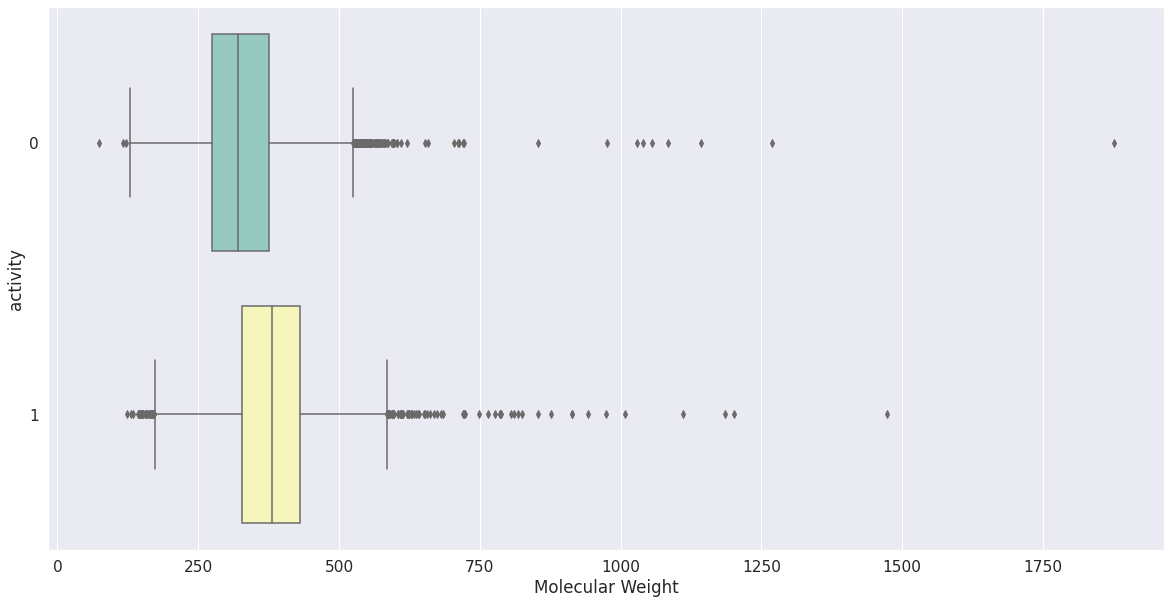

In [36]:
generate_box_plot("Molecular Weight", "activity", "", molecular_descriptors, "h")

In [37]:
moldes_1["Molecular Weight"].describe()

count    19992.000000
mean       379.753045
std         75.095935
min        123.079647
25%        327.172542
50%        380.083078
75%        430.200491
max       1472.581284
Name: Molecular Weight, dtype: float64

In [38]:
moldes_0["Molecular Weight"].describe()

count    19998.000000
mean       328.967866
std         77.149590
min         74.036779
25%        275.163377
50%        321.199625
75%        375.157620
max       1875.540932
Name: Molecular Weight, dtype: float64

Comparing both box plots, we can observe that the median molecular weight is slightly higher on the active molecules.

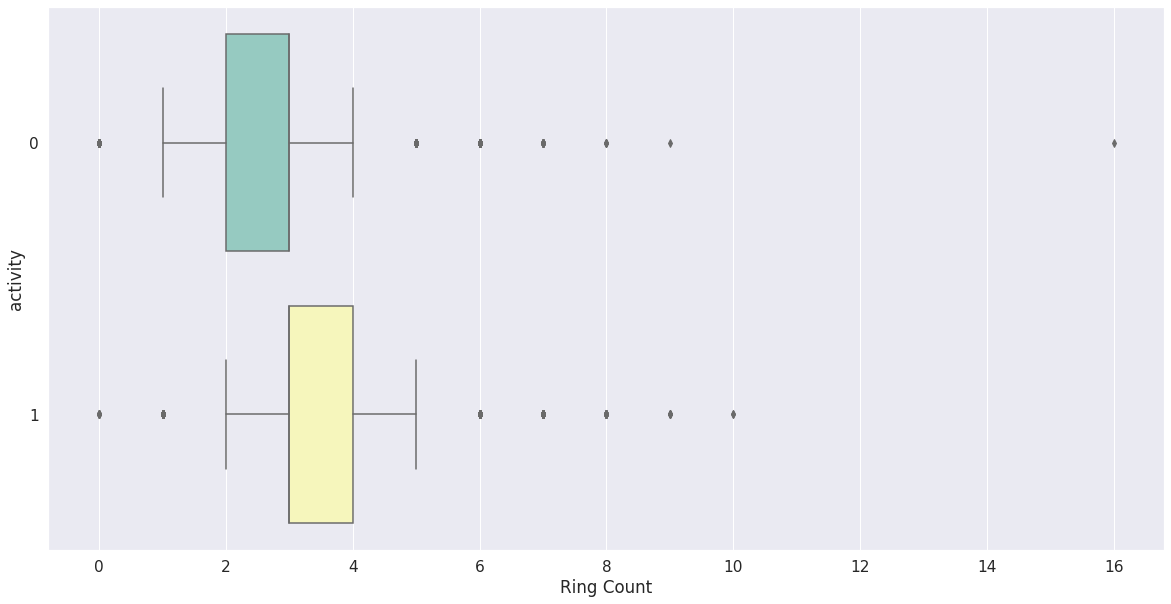

In [39]:
generate_box_plot("Ring Count", "activity", "", molecular_descriptors, "h")

In [40]:
moldes_1["Ring Count"].describe()

count    19992.000000
mean         3.465886
std          1.046962
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: Ring Count, dtype: float64

In [41]:
moldes_0["Ring Count"].describe()

count    19998.000000
mean         2.732373
std          0.924939
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         16.000000
Name: Ring Count, dtype: float64

Comparing both box plots, we can observe that the median ring count is slightly higher on the active molecules.

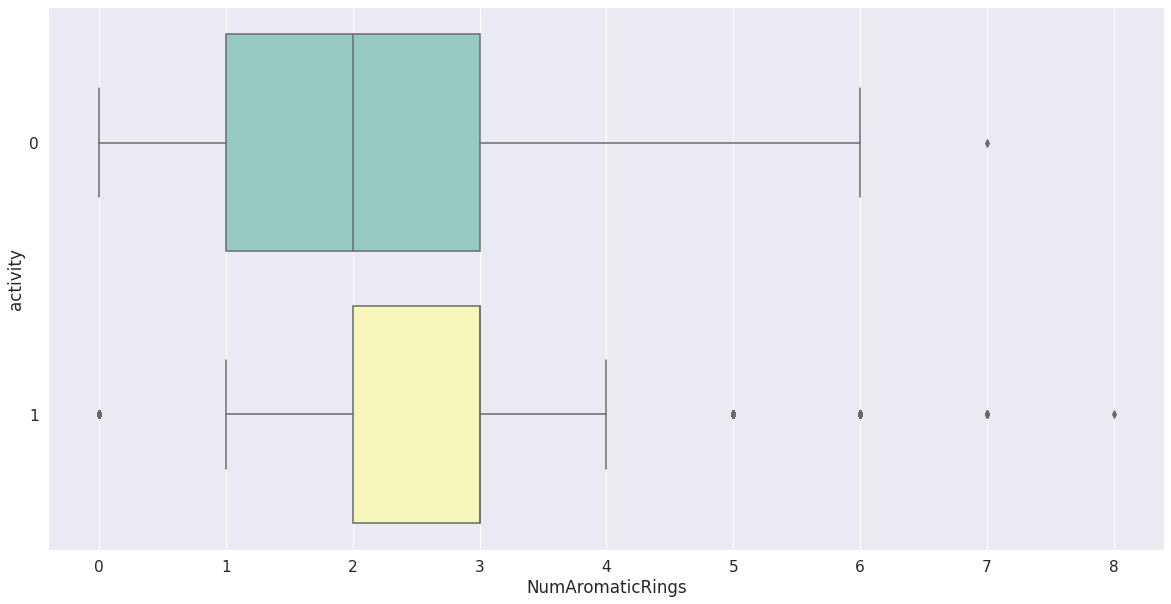

In [42]:
generate_box_plot("NumAromaticRings", "activity", "", molecular_descriptors, "h")

In [43]:
moldes_1["NumAromaticRings"].describe()

count    19992.000000
mean         2.682823
std          0.942225
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          8.000000
Name: NumAromaticRings, dtype: float64

In [44]:
moldes_0["NumAromaticRings"].describe()

count    19998.000000
mean         2.047405
std          0.885365
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: NumAromaticRings, dtype: float64

Comparing both box plots, we can observe that the median number of aromatic rings is slightly higher on the active molecules.

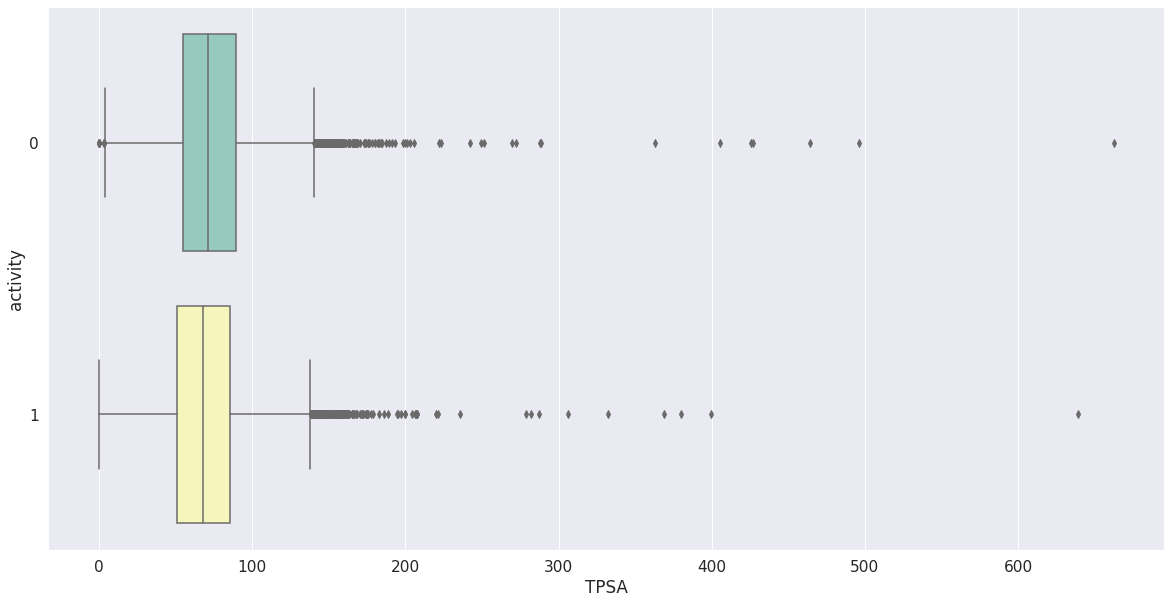

In [45]:
generate_box_plot("TPSA", "activity", "", molecular_descriptors, "h")

In [46]:
moldes_1["TPSA"].describe()

count    19992.000000
mean        69.187245
std         27.726477
min          0.000000
25%         50.720000
50%         68.020000
75%         85.610000
max        639.100000
Name: TPSA, dtype: float64

In [47]:
moldes_0["TPSA"].describe()

count    19998.000000
mean        73.075755
std         27.698442
min          0.000000
25%         54.880000
50%         71.090000
75%         89.130000
max        662.410000
Name: TPSA, dtype: float64

Unlike the previous results, we can observe that the active molecules have a slightly lower median topological polar surface area than the inactive ones.

# FIM TESTE

## Feature generation

In [45]:
loader = CSVLoader("../dataset/standardized.csv",
                   mols_field='mols',
                   labels_fields='y')

dataset_des = loader.create_dataset()
dataset_finger = copy.deepcopy(dataset_des)

### Molecular descriptors

In [46]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = list(calc.GetDescriptorNames())
header

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

In [47]:
TwoDimensionDescriptors().featurize(dataset_des)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

### Normalize data

In [48]:
StandardScaler().fit_transform(dataset_des)

#### Create dataframe with feature names

In [49]:
descript_data = pd.DataFrame(dataset_des.X, columns=header)
descript_data

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           -2.309058        1.056768          -2.309058           2.312571   
1           -0.403641        0.048231          -0.403641          -0.048228   
2            0.623985       -0.445262           0.623985          -0.849569   
3            0.366186       -0.339224           0.366186          -0.838786   
4            0.649409       -0.115829           0.649409          -0.629246   
...               ...             ...                ...                ...   
39984        0.537131       -2.013391           0.537131           0.256075   
39985        0.111571        0.185405           0.111571          -0.510782   
39986        0.904540        0.288651           0.904540          -0.558972   
39987        0.888645        0.321952           0.888645          -0.236677   
39988       -0.633836        0.869762          -0.633836           1.005882   

            qed     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.735588 -1.020753       -0.987390   -1.025228            -1.137671   
1      0.315403  0.043725        0.030114    0.034173            -0.141276   
2     -3.062047  3.758309        3.645877    3.762526             4.176435   
3     -2.274838  1.527398        1.569467    1.530413             1.652235   
4     -2.755876  2.314300        2.227825    2.315842             2.316498   
...         ...       ...             ...         ...                  ...   
39984  0.686796  0.419833        0.387330    0.421016             0.456561   
39985 -0.447139 -1.487964       -1.427513   -1.486574            -1.403376   
39986 -0.756582  1.579072        1.412164    1.581587             1.984366   
39987 -0.362638  1.404497        1.254401    1.406940             1.785087   
39988  0.237715 -0.464519       -0.532754   -0.463304            -0.274129   

       NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                      0.0         -1.766876          0.780127   
1                      0.0          0.553593         -0.798850   
2                      0.0          1.230107         -0.542882   
3                      0.0          0.885616         -0.798838   
4                      0.0          0.933521         -0.471091   
...                    ...               ...               ...   
39984                  0.0         -0.313068         -0.934755   
39985                  0.0          0.074856          1.139343   
39986                  0.0         -1.496971         -1.098522   
39987                  0.0         -1.496971         -0.950347   
39988                  0.0         -2.107540         -1.142377   

       MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0                -0.828210            -1.817133          0.757854   
1                 0.788688             0.613304          0.984249   
2                 0.526572             1.321878         -2.091890   
3                 0.788675             0.961062         -0.217442   
4                 0.453057             1.011237         -0.993914   
...                    ...                  ...               ...   
39984             0.927856            -0.294428         -0.077852   
39985            -1.196053             0.111879          1.574653   
39986             1.095556            -1.534437         -0.845599   
39987             0.943823            -1.534437         -1.658509   
39988             1.140464            -2.173942         -2.749701   

       FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  \
0              1.327942          1.333505     0.598376      0.270698   
1              0.662511          0.339321     0.598453      0.850986   
2             -2.386200         -2.220005    -0.769387     -0.230429   
3             -0.180368         -0.286731    -0.788016     -1.192306   
4             -0.859354         -0.810839     0.425762     -0.441730   
...                 ...               ...          ...           ..

In [50]:
descript_data.shape

(39989, 208)

### Generate Fingerprints

In [51]:
dataset_morgan = copy.deepcopy(dataset_finger)
dataset_rdk = copy.deepcopy(dataset_finger)
dataset_macc = copy.deepcopy(dataset_finger)

In [52]:
MorganFingerprint().featurize(dataset_morgan)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

In [53]:
MACCSkeysFingerprint().featurize(dataset_rdk)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

In [54]:
RDKFingerprint().featurize(dataset_macc)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

## Feature Selection

#### Descriptors

In [55]:
from boruta.boruta_py import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(estimator=rf, max_iter=10, n_estimators=100)

feat_selector.fit(X=dataset_des.X, y=dataset_des.y)
X_filtered = feat_selector.transform(X=dataset_des.X)

[  1   1   1   1   1   1   1   1   2 117   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1 117   1   1   1   1   1   6  11   1  27  31   1  13  22
  28   2   1   1   2   1   1  72   1  32   2   1   1 117  29   4   3  41
  15   1   1  24   1   1  53   1 117   1   5   2 109   1   1   1   8   8
   6   1  10   1   1   1   1   1   1   1   1   1  17   1   2  12   1  64
  43  47   2  35   1  19  22  14  19  81  39  44   1   1   1  49  76  79
  87  62  26  60  50  16  24   1   1  52 101  73  30  21  65  94  90  75
  61 109  98 105  70  41   1  86  34  45 117  97 100   1 117  18 117  99
 103  68  46  77  89  33  88  67  81  74 117 117  37  51 107  96  54  84
  80  54  71  92 108  95  90  48  37  36 111 111  56  57  93 117  58 104
  40  62  78 102  59  85 106  83  68  66]


In [63]:
feat_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True, False, False,  True, False, False,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False,  True,  True, False,  True,  True, False,  True, False,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,

In [58]:
# descript_data = pd.DataFrame(dataset_des.X, columns=header)
# descript_data

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           -2.309058        1.056768          -2.309058           2.312571   
1           -0.403641        0.048231          -0.403641          -0.048228   
2            0.623985       -0.445262           0.623985          -0.849569   
3            0.366186       -0.339224           0.366186          -0.838786   
4            0.649409       -0.115829           0.649409          -0.629246   
...               ...             ...                ...                ...   
39984        0.537131       -2.013391           0.537131           0.256075   
39985        0.111571        0.185405           0.111571          -0.510782   
39986        0.904540        0.288651           0.904540          -0.558972   
39987        0.888645        0.321952           0.888645          -0.236677   
39988       -0.633836        0.869762          -0.633836           1.005882   

            qed     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.735588 -1.020753       -0.987390   -1.025228            -1.137671   
1      0.315403  0.043725        0.030114    0.034173            -0.141276   
2     -3.062047  3.758309        3.645877    3.762526             4.176435   
3     -2.274838  1.527398        1.569467    1.530413             1.652235   
4     -2.755876  2.314300        2.227825    2.315842             2.316498   
...         ...       ...             ...         ...                  ...   
39984  0.686796  0.419833        0.387330    0.421016             0.456561   
39985 -0.447139 -1.487964       -1.427513   -1.486574            -1.403376   
39986 -0.756582  1.579072        1.412164    1.581587             1.984366   
39987 -0.362638  1.404497        1.254401    1.406940             1.785087   
39988  0.237715 -0.464519       -0.532754   -0.463304            -0.274129   

       NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                      0.0         -1.766876          0.780127   
1                      0.0          0.553593         -0.798850   
2                      0.0          1.230107         -0.542882   
3                      0.0          0.885616         -0.798838   
4                      0.0          0.933521         -0.471091   
...                    ...               ...               ...   
39984                  0.0         -0.313068         -0.934755   
39985                  0.0          0.074856          1.139343   
39986                  0.0         -1.496971         -1.098522   
39987                  0.0         -1.496971         -0.950347   
39988                  0.0         -2.107540         -1.142377   

       MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0                -0.828210            -1.817133          0.757854   
1                 0.788688             0.613304          0.984249   
2                 0.526572             1.321878         -2.091890   
3                 0.788675             0.961062         -0.217442   
4                 0.453057             1.011237         -0.993914   
...                    ...                  ...               ...   
39984             0.927856            -0.294428         -0.077852   
39985            -1.196053             0.111879          1.574653   
39986             1.095556            -1.534437         -0.845599   
39987             0.943823            -1.534437         -1.658509   
39988             1.140464            -2.173942         -2.749701   

       FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  \
0              1.327942          1.333505     0.598376      0.270698   
1              0.662511          0.339321     0.598453      0.850986   
2             -2.386200         -2.220005    -0.769387     -0.230429   
3             -0.180368         -0.286731    -0.788016     -1.192306   
4             -0.859354         -0.810839     0.425762     -0.441730   
...                 ...               ...          ...           ..

In [ ]:
# BorutaAlgorithm(max_iter=10, n_estimators=100).select_features(descript_data)

#### Fingerprints

In [ ]:
from sklearn.feature_selection import SelectPercentile

In [ ]:
SelectPercentile(percentile=20).fit_transform(dataset_morgan.X, dataset_morgan.y)
dataset_morgan.X.shape

In [ ]:
SelectPercentile(percentile=20).fit_transform(dataset_rdk.X, dataset_rdk.y)
dataset_rdk.X.shape

In [ ]:
SelectPercentile(percentile=20).fit_transform(dataset_macc.X, dataset_macc.y)
dataset_macc.X.shape

## Unsupervised exploration

**Principal Component Analysis (PCA)** is a dimension-reduction tool and a statistical procedure that can be used to reduce a large set of variables to a small set that still contains most of the information of the large set. It uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components (PC). This procedure can explain the variance-covariance structure of the data.

**t-distributed Stochastic Neighbor Embedding (t-SNE)** is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

**k-means clustering** is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centroid), serving as a prototype of the cluster.

### Descriptors

### Fingerprints

In [ ]:
##Fazer Unsupervised para Fingerprints sendo que para os descritores não é necessário generate_similarities.
def generate_similarities(fps):
    similarities_list = []
    bv1 = DataStructs.ExplicitBitVect(fps.shape[1])

    new_fps = []
    for fp in fps:

        bv12 = copy.copy(bv1)
        for i, bit in enumerate(fp):
            if bit == 1:
               bv12.SetBit(i)
        new_fps.append(bv12)

    for i in range(0,1000):  # 2000
        remaining_fp = new_fps[:i] + new_fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(new_fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)

    return np.transpose(np.array(similarities_list))

### MorganFingerprint

In [ ]:
similarities = generate_similarities(dataset_morgan.X)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=100)
df = pca.fit_transform(similarities)

labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

In [ ]:
plt.figure()
plt.plot(range(1,101),np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Comulative Explained Variance')
plt.xlim(1,100)
plt.ylim(20,100)
plt.axhline(y=95, color='r')
plt.axvline(x=90, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

The first two principal components explain 31% of the data variance.
To explain 95% of the variance, 90 principal components are required.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE(n_components=2)
tsne_df = tsne.fit_transform(df[:, 0:2])  # selecionar os dois primeiros componentes

In [ ]:
labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

### k-means

In [ ]:
distortions = []
for i in range(1, 21):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=15)
kmeans_y = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(kmeans_y)

#plotting the results:
for i in u_labels:
    plt.scatter(df[kmeans_y == i , 0] , df[kmeans_y == i , 1] , label = i)
plt.legend()
plt.show()

### RDKFingerprint

In [ ]:
similarities = generate_similarities(dataset_rdk.X)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=100)
df = pca.fit_transform(similarities)

In [ ]:
labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

In [ ]:
plt.figure()
plt.plot(range(1,101),np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Comulative Explained Variance')
plt.xlim(1,30)
plt.ylim(80,100)
plt.axhline(y=95, color='r')
plt.axvline(x=15, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

The first two principal components explain 86% of the data variance.
To explain 95% of the variance, 15 principal components are required.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE()
tsne_df = tsne.fit_transform(df[:, 0:2])  # selecionar os dois primeiros componentes

In [ ]:
labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

### k-means

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans_y = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(kmeans_y)

#plotting the results:
for i in u_labels:
    plt.scatter(df[kmeans_y == i, 0], df[kmeans_y == i, 1], label=i)
plt.legend()
plt.show()

### MACCSkeysFingerprint

In [ ]:
similarities = generate_similarities(dataset_macc.X)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=100)
df = pca.fit_transform(similarities)

In [ ]:
labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

In [ ]:
plt.figure()
plt.plot(range(1, 101), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Comulative Explained Variance')
plt.xlim(1, 30)
plt.ylim(40, 100)
plt.axhline(y=95, color='r')
plt.axvline(x=16, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

The first two principal components explain 59% of the data variance.
To explain 95% of the variance, 16 principal components are required.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE()
tsne_df = tsne.fit_transform(df[:, 0:2])  # selecionar os dois primeiros componentes

In [ ]:
labels = dataset.y
plt.figure(figsize=(20, 20))
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

### k-means

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans_y = kmeans.fit_predict(df)
u_labels = np.unique(kmeans_y)

#plotting the results:
for i in u_labels:
    plt.scatter(df[kmeans_y == i, 0], df[kmeans_y == i, 1], label=i)
plt.legend()
plt.show()